# Exploratory Data Analysis

- Dataset Overview
- Summary Statistics
- Vizualizing Distributions
- Exploring Relationships
- Data Quality Checks

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/kolesnikevgenia/Documents/Python_Projects/Job_Skills/Raw_Data/df_Final.csv')

### Dataset Overview

In [35]:
df.shape


(22002, 22)

In [36]:
df.dtypes

job_title_short           object
job_title                 object
job_location              object
job_via                   object
job_schedule_type         object
job_work_from_home          bool
search_location           object
job_posted_date           object
job_no_degree_mention       bool
job_health_insurance        bool
job_country               object
salary_rate               object
company_name              object
job_skills                object
job_type_skills           object
salary_year_avg_eur      float64
salary_month_avg_eur     float64
country                   object
is_eu                       bool
ISO                       object
country_group             object
region_group              object
dtype: object

In [37]:
df.isna().sum()

job_title_short              0
job_title                    0
job_location               280
job_via                      0
job_schedule_type           16
job_work_from_home           0
search_location              0
job_posted_date              0
job_no_degree_mention        0
job_health_insurance         0
job_country                  0
salary_rate                  0
company_name                 0
job_skills                1833
job_type_skills           1833
salary_year_avg_eur          0
salary_month_avg_eur         0
country                  20348
is_eu                        0
ISO                      20348
country_group                0
region_group                 0
dtype: int64

### Summary Statistics

In [38]:
#Numeric column
df['salary_month_avg_eur'].describe().round(0).astype(int)

count    22002
mean      8849
std       3468
min       1077
25%       6460
50%       8254
75%      10766
max      68904
Name: salary_month_avg_eur, dtype: int64

In [39]:
#Categorical counts, Job Title
df['job_title_short'].value_counts().head(10)

job_title_short
Data Scientist               5922
Data Analyst                 5450
Data Engineer                4500
Senior Data Scientist        1690
Senior Data Engineer         1591
Senior Data Analyst          1131
Business Analyst              610
Machine Learning Engineer     576
Software Engineer             467
Cloud Engineer                 65
Name: count, dtype: int64

In [40]:
#Categorical counts, country_group
df['country_group'].value_counts().head(10)

country_group
United States     15765
European Union     1654
Sudan              1623
India               582
Canada              463
United Kingdom      287
Mexico              111
Israel              103
Singapore            98
South Africa         92
Name: count, dtype: int64

In [41]:
#Categorical counts, EU countries
df[df['region_group'] == 'EU']['job_country'].value_counts().head(10)

job_country
Germany        257
France         237
Poland         200
Spain          144
Portugal       131
Netherlands     87
Greece          82
Hungary         62
Belgium         57
Ireland         53
Name: count, dtype: int64

In [42]:
#Median salary by country, monthly (EUR)
df.groupby('job_country')['salary_month_avg_eur'].median().sort_values(ascending=False).round(0).astype(int).head(10)

job_country
Belarus                     28710
Russia                      21532
Bahamas                     14937
Dominican Republic          11305
Northern Mariana Islands    11160
Tunisia                     10587
Côte d'Ivoire               10587
Chile                       10479
Namibia                      9833
Sudan                        9295
Name: salary_month_avg_eur, dtype: int64

In [43]:
#Exploring median salaries by country
df = df.dropna(subset=['salary_month_avg_eur'])

country_salary_stats = (
    df.groupby('job_country')
    .agg(job_count=('salary_month_avg_eur', 'count'),
         avg_salary=('salary_month_avg_eur', 'mean'))
         .sort_values(by='avg_salary', ascending=False)
         ).round(0).astype(int)

country_salary_stats.head(10)

,job_count,avg_salary
job_country,,
Belarus,1,28710
Russia,4,20994
Bahamas,21,14463
Dominican Republic,1,11305
Northern Mariana Islands,1,11160
Côte d'Ivoire,1,10587
Namibia,7,10110
Sudan,1623,9622
United States,15765,9053


### Visualizing Distributions

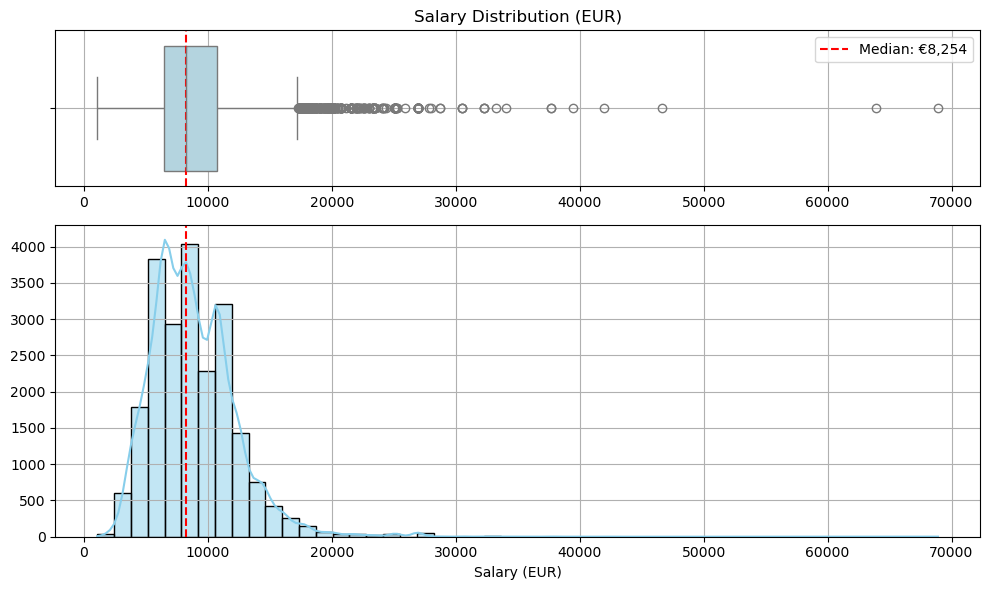

In [44]:
data = df['salary_month_avg_eur'].dropna()
median_salary = data.median()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]})

# --- Boxplot
sns.boxplot(x=data, ax=ax1, color='lightblue')
ax1.axvline(median_salary, color='red', linestyle='--', label=f'Median: €{median_salary:,.0f}')
ax1.set_title('Salary Distribution (EUR)')
ax1.set_xlabel('')
ax1.grid(True)
ax1.legend()

# --- Histogram
sns.histplot(data, bins=50, kde=True, ax=ax2, color='skyblue', edgecolor='black')
ax2.axvline(median_salary, color='red', linestyle='--', label=f'Median: €{median_salary:,.0f}')
ax2.set_xlabel('Salary (EUR)')
ax2.set_ylabel('')
ax2.grid(True)

plt.tight_layout()
plt.show()

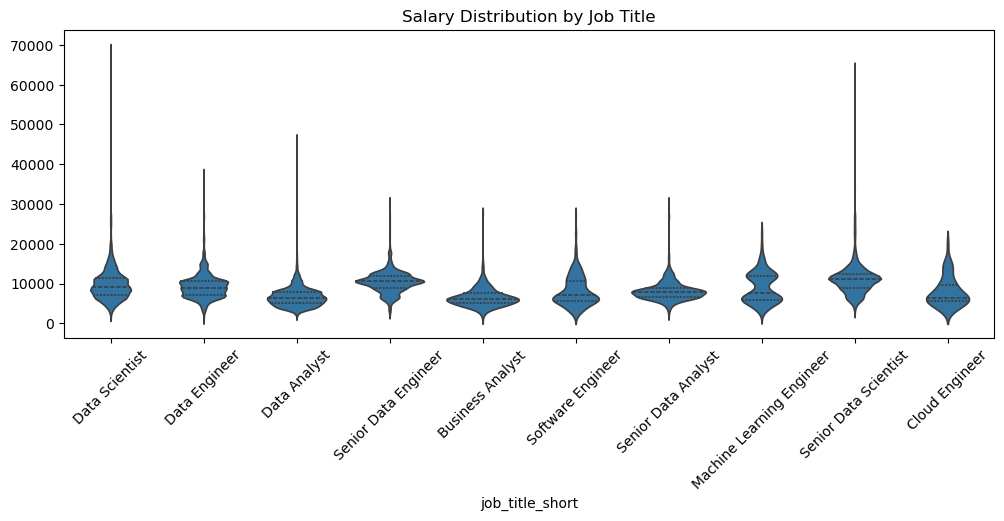

In [45]:
plt.figure(figsize=(12, 4))
sns.violinplot(data=df, x='job_title_short', y='salary_month_avg_eur', inner='quartile')
plt.xticks(rotation=45)
plt.ylabel('')
plt.title('Salary Distribution by Job Title')
plt.show()

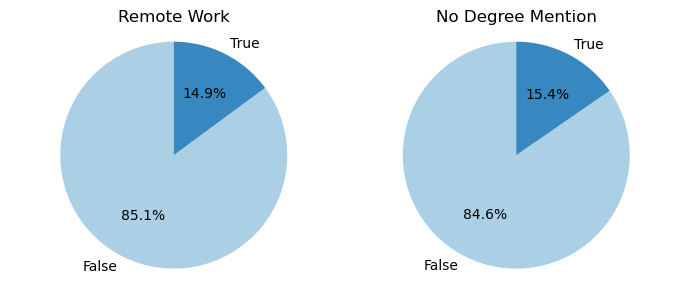

In [46]:
remote_counts = df['job_work_from_home'].value_counts()
degree_counts = df['job_no_degree_mention'].value_counts()

# Shared color palette
shared_colors = sns.color_palette("Blues", n_colors=2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Remote Work Pie Chart
axes[0].pie(
    remote_counts,
    labels=remote_counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    colors=shared_colors
)
axes[0].set_title('Remote Work')
axes[0].axis('equal')

# No Degree Mention Pie Chart
axes[1].pie(
    degree_counts,
    labels=degree_counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    colors=shared_colors
)
axes[1].set_title('No Degree Mention')
axes[1].axis('equal')

# Layout
plt.tight_layout()
plt.show()

### Exploring Relationships

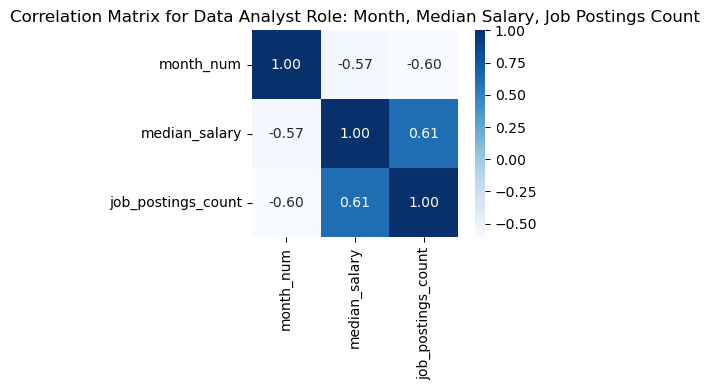

In [47]:
df_da = df[(df['job_title_short'] == 'Data Analyst')].copy()

df_da['job_posted_date'] = pd.to_datetime(df_da['job_posted_date'])
df_da['month_num'] = df_da['job_posted_date'].dt.month

# Group by month to get median salary and job count
monthly_stats = df_da.groupby('month_num').agg(
    median_salary=('salary_month_avg_eur', 'median'),
    job_postings_count=('salary_month_avg_eur', 'count')  # or 'size' if column doesn't matter
).reset_index()

# Correlation matrix
correlation_matrix = monthly_stats.corr(numeric_only=True)

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.title('Correlation Matrix for Data Analyst Role: Month, Median Salary, Job Postings Count')
plt.tight_layout()
plt.show()

#### Strong Negative Correlation Between Month and Number of Job Postings (−0.60)
There is a clear downward trend in job postings as the year progresses. This suggests that more positions are typically available earlier in the year, with fewer opportunities later on (depending on how months are numbered). This pattern likely reflects hiring cycles, budget timelines, or seasonal fluctuations in the job market. A deeper analysis could help identify the best time of year to actively search for a job.

#### Strong Positive Correlation Between Monthly Salary and Number of Job Postings (0.61)
An increase in the number of job postings is also associated with higher salaries. This indicates that during peak hiring periods, companies may offer more competitive compensation. Identifying these peak months can help job seekers maximize their salary potential when entering the job market.

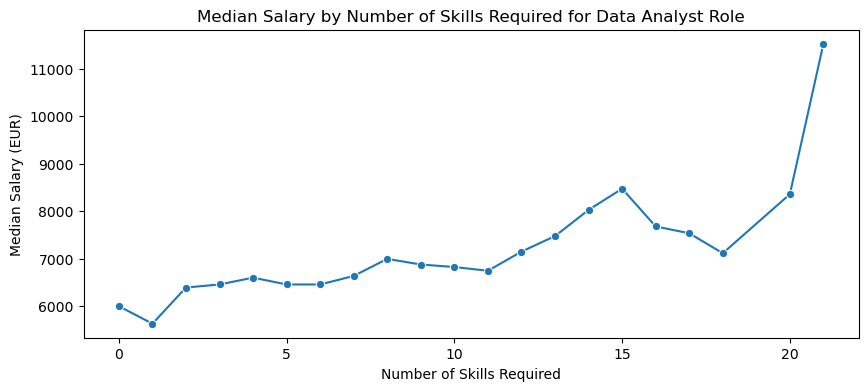

In [48]:
# Filter dataset to Data Analyst only
df_da = df[df['job_title_short'] == 'Data Analyst'].copy()

# Count skills function (comma-separated assumed)
def count_skills(skills_str):
    if pd.isna(skills_str) or skills_str.strip() == '':
        return 0
    return len([s for s in skills_str.split(',') if s.strip() != ''])

# Add skills_count column
df_da['skills_count'] = df_da['job_skills'].apply(count_skills)

# Median salary by skills count
median_salary_by_skills = df_da.groupby('skills_count')['salary_month_avg_eur'].median().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x='skills_count', y='salary_month_avg_eur', data=median_salary_by_skills, marker='o')
plt.title('Median Salary by Number of Skills Required for Data Analyst Role')
plt.xlabel('Number of Skills Required')
plt.ylabel('Median Salary (EUR)')
plt.show()

### Spotting Issues

In [49]:
# Check for duplicates
print(df.duplicated().sum())

0
